In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/data_train_2-20250516T083407Z-1-001.zip

Archive:  /content/data_train_2-20250516T083407Z-1-001.zip
  inflating: data_train_2/SUV-Crossover_MPV/Car_931.png  
  inflating: data_train_2/SUV-Crossover_MPV/Car_9.png  
  inflating: data_train_2/Bus/Bus_39.png  
  inflating: data_train_2/SUV-Crossover_MPV/Car_730.png  
  inflating: data_train_2/Bus/Bus_90.png  
  inflating: data_train_2/Bus/Bus_41.png  
  inflating: data_train_2/SUV-Crossover_MPV/Car_522.png  
  inflating: data_train_2/Bus/Bus_7.png  
  inflating: data_train_2/SUV-Crossover_MPV/Car_543.png  
  inflating: data_train_2/Bus/Bus_5.png  
  inflating: data_train_2/SUV-Crossover_MPV/Car_836.png  
  inflating: data_train_2/SUV-Crossover_MPV/Car_835.png  
  inflating: data_train_2/SUV-Crossover_MPV/Car_456.png  
  inflating: data_train_2/Bus/Bus_40.png  
  inflating: data_train_2/Bus/Bus_9.png  
  inflating: data_train_2/Bus/Bus_50.png  
  inflating: data_train_2/Bus/Bus_80.png  
  inflating: data_train_2/SUV-Crossover_MPV/Car_403.png  
  inflating: data_train_2/Bus/Bus_60.

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#master_path = "/content/drive/MyDrive/Do_An/data_train_2" # Phat's link
master_path = "/content/drive/MyDrive/Hoc/ComputerVision/Do_An/data_train_2" # Nguyen's link
# master_path = "/content/drive/MyDrive/Colab Notebooks/data/Dataset"
#master_path = '/content/data_train_2'

In [ ]:
label2idx = {}
idx2label = {}
count = 0
for idx, label in enumerate(os.listdir(master_path)):
  if(label not in ['train_set', 'data_test', 'data_demo']):
    label2idx[label] = count
    idx2label[count] = label
    count += 1

label2idx, idx2label

({'SUV-Crossover_MPV': 0,
  'Truck-hafl_truck': 1,
  'Bus': 2,
  'Sedan': 3,
  'Container': 4},
 {0: 'SUV-Crossover_MPV',
  1: 'Truck-hafl_truck',
  2: 'Bus',
  3: 'Sedan',
  4: 'Container'})

In [ ]:
list_file = {}

for label in label2idx.keys():
  list_file[label] = []
  for file in os.listdir(os.path.join(master_path, label)):
    list_file[label].append(file)

# Thăm dò bộ dữ liệu

In [ ]:
data = [(filename, label) for label, files in list_file.items() for filename in files]
df = pd.DataFrame(data, columns=["path", "label"])

df

,path,label
0,frame_03180_00002.jpg,Container
1,frame_36000_00000.jpg,Container
2,3.png,Container
3,frame_06600_00005.jpg,Container
4,frame_01200_00003.jpg,Container
...,...,...
231,Car_265.png,Sedan
232,Car_19.png,Sedan
233,Car_615.png,Sedan
234,Car_408.png,Sedan


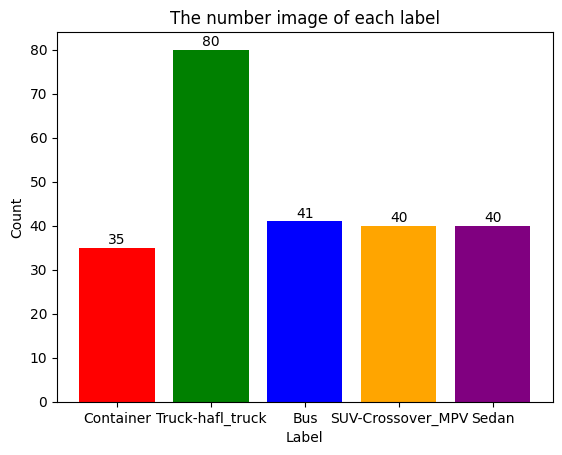

In [ ]:
count=[]
for label in label2idx.keys():
  count.append(df['label'].loc[df['label'] == label].count())

plt.bar(x=label2idx.keys(), height=count, color = ['red', 'green', 'blue', 'orange', 'purple', 'yellow'])
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("The number image of each label")

for i, value in enumerate(count):
    plt.text(x=i, y=value + 0.1, s=str(value), ha='center', va='bottom')

plt.show()

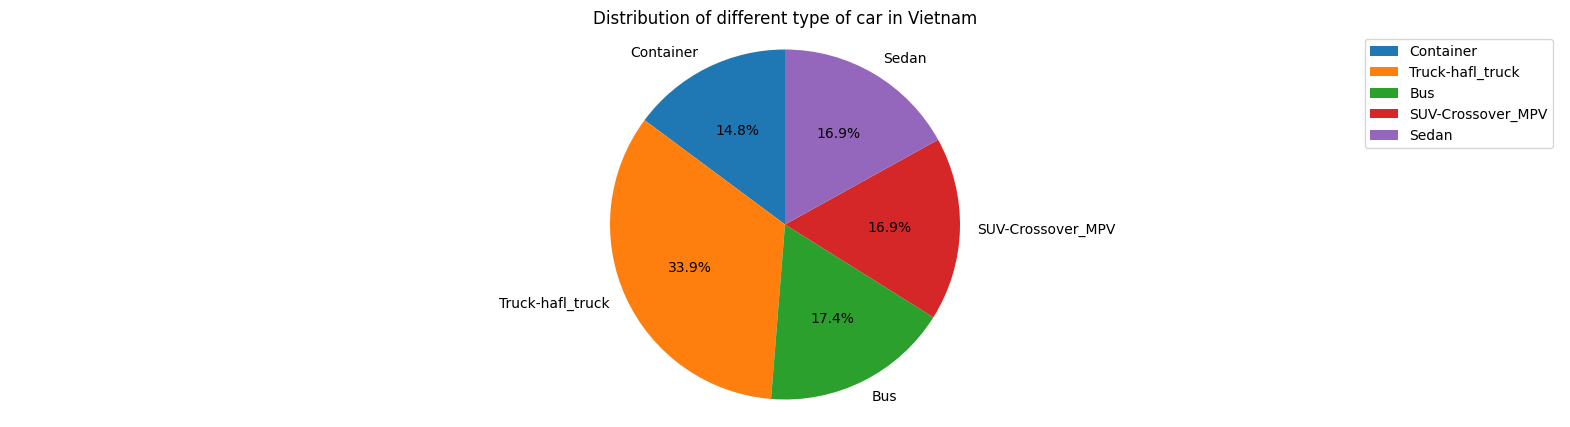

In [ ]:
plt.figure(figsize=(20,5))
plt.pie(x=count, labels=label2idx.keys(), autopct='%1.1f%%', startangle=90)
plt.title("Distribution of different type of car in Vietnam")
plt.axis('equal')
plt.legend()
plt.show()

# Extract features function

In [ ]:
X = []
y = []

for idx, label in enumerate(os.listdir(master_path)):
  count = 0
  if(label not in ['train_set', 'data_test', 'data_demo']):
    path = os.path.join(master_path, label)

    list_img = [os.path.join(path, img) for img in os.listdir(path) if img.endswith(('jpg', 'png'))]
    for img in list_img:
      count += 1
      image = cv2.imread(img)
      image = cv2.resize(image, (128,128))
      # image = np.expand_dims(image, axis=0)
      X.append(image)
      y.append(label2idx[label])
X = np.array(X)
y = np.array(y)

In [ ]:
X.shape

(236, 128, 128, 3)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RESNET50

In [ ]:
from keras.applications import VGG16

vgg = VGG16(include_top=False, input_shape=(128, 128, 3))
for layer in vgg.layers:
  layer.trainable = False

from keras.layers import Flatten, Dense, Input
from keras.models import Model

output = Flatten()(vgg.layers[-1].output)

model = Model(inputs = vgg.inputs, outputs = output)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
def get_feature_resnet(data):
  from keras.applications import ResNet50

  resnet = ResNet50(include_top=False, input_shape=(128, 128, 3))
  for layer in resnet.layers:
    layer.trainable = False

  from keras.layers import Flatten, Dense, Input
  from keras.models import Model

  output = Flatten()(resnet.layers[-1].output)

  model = Model(inputs = resnet.inputs, outputs = output)

  return model(data)

In [ ]:
def get_feature_vgg(data):
  from keras.applications import VGG16

  vgg = VGG16(include_top=False, input_shape=(128, 128, 3))
  for layer in vgg.layers:
    layer.trainable = False

  from keras.layers import Flatten, Dense, Input
  from keras.models import Model

  output = Flatten()(vgg.layers[-1].output)

  model = Model(inputs = vgg.inputs, outputs = output)

  return model(data)

In [ ]:
X_train_feature = get_feature_resnet(X_train)
X_test_feature = get_feature_resnet(X_test)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_20']
Received: inputs=Tensor(shape=(188, 128, 128, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_196']
Received: inputs=Tensor(shape=(48, 128, 128, 3))
  warnings.warn(msg)


## Xây dựng mô hình KNN

In [ ]:
model4classifier = KNeighborsClassifier(algorithm='auto', n_neighbors=3, weights='distance')

model4classifier.fit(X_train_feature, y_train)

y_pred = model4classifier.predict(X_test_feature)

In [ ]:
# đánh giá mô hình
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.56      0.50      0.53        10
           1       1.00      0.87      0.93        15
           2       0.75      1.00      0.86         6
           3       0.70      0.50      0.58        14
           4       0.38      1.00      0.55         3

    accuracy                           0.71        48
   macro avg       0.68      0.77      0.69        48
weighted avg       0.75      0.71      0.71        48



## Xây dựng mô hình SVM

In [ ]:
svc = SVC(C=10, gamma='scale', kernel='linear')

svc.fit(X_train_feature, y_train)

y_pred = svc.predict(X_test_feature)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78         9
           1       1.00      0.93      0.96        14
           2       0.88      1.00      0.93         7
           3       0.80      0.80      0.80        10
           4       1.00      1.00      1.00         8

    accuracy                           0.90        48
   macro avg       0.89      0.90      0.89        48
weighted avg       0.90      0.90      0.90        48



In [ ]:
from joblib import dump, load

# Lưu mô hình ra file
dump(svc, 'svm_model(RESNET).pkl')

['svm_model(RESNET).pkl']